In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def data_set_maker(raw_data, input_dim, target_dis):
    X = []
    Y = []
    record_length = raw_data.shape[0] - (input_dim + target_dis - 1)
    for i in range(record_length):
        X.append(raw_data[i : i + input_dim])
        Y.append(raw_data[i + input_dim + target_dis - 1])
    X = np.array(X).reshape(record_length, -1)
    Y = np.array(Y).reshape(-1, 1)
    return X, Y

def set_division(X, Y, split_ratio):
    n = int(X.shape[0] * split_ratio)
    X_train, Y_train = np.copy(X[ :n]), np.copy(Y[ :n])
    X_test, Y_test = np.copy(X[n: ]), np.copy(Y[n: ])
    return X_train, Y_train, X_test, Y_test

def sigmoid(x):
    z = 1 / (1 + np.exp(x))
    return z

def tanh(net):
    nominator = np.exp(x) - np.exp(x)
    denominator = np.exp(x) + np.exp(-x)
    z = nominator / denominator
    return z

def activate(activation_func, x):
    if activation_func == 'sigmoid':
        return sigmoid(x)
    elif activation_func == 'tanh':
        return tanh(x)

def activate_der(activation_func, x):
    if activation_func == 'sigmoid':
        z = sigmoid(x)
        z = z * (1 - z)
        return z
    else:
        z = tanh(x)
        z = (1 - z ** 2)
        return z

In [17]:
class NN_Elman():
    
    #instanciate an object of network
    #structure is a list of dimensions: [5,3,3] means a network with input of dimension 5, one hidden
    #layers of size 3 and an output of 3 dimension. activate is its type of activation functions in a list
    def __init__(self, structure, activation_type, truncate_size,
                 eta_Wy= 0.0001, eta_Wx= 0.0001, eta_Wc= 0.0001):

        #keep activation function type for each layer
        self.act = activation_type
        #keep structure of network
        self.structure = structure
        self.truncate_size = truncate_size
        #keep matrices of Weights
        self.Wy = np.random.uniform(low= 0.1 ,high= 0.9 ,size= (structure[2], structure[1]))
        self.Wx = np.random.uniform(low= 0.1 ,high= 0.9 ,size= (structure[1], structure[0]))
        self.Wc = np.random.uniform(low= 0.1 ,high= 0.9 ,size= (structure[1], structure[1]))
        #keep vectors of different etas
        self.eta_Wy = eta_Wy
        self.eta_Wx = eta_Wx
        self.eta_Wc = eta_Wc
        #keep change of Weights
        self.Wy_U = np.zeros(self.Wy.shape)
        self.Wx_U = np.zeros(self.Wx.shape)
        self.Wc_U = np.zeros(self.Wc.shape)
        
    def step_feed_fwd(self, x, previous_state):
        net = np.dot(self.Wx, x.reshape(-1,1)) + np.dot(self.Wc, previous_state.reshape(-1,1))
        state = activate(self.act, net)
        output = np.dot(self.Wy, state)
        return output, state

    def feed_fwd(self, record):
        input_vector, net, state, output = [], [], [], []
        previous_state = np.zeros([self.structure[1], 1])
        for t in range(record.shape[0]):
            x = np.zeros([record.shape[0], 1])
            x[t] = record[t]
            input_vector.append(x)
            net.append(np.dot(self.Wx, x) + np.dot(self.Wc, previous_state))
            s = activate(self.act, net[t])
            state.append(s)
            previous_state = s
            output.append(np.dot(self.Wy, state[t]))
        input_vector = np.array(input_vector)
        net = np.array(net)
        state = np.array(state)
        output = np.array(output)
        return input_vector, net, state, output
            
    def back_pro(self, input_vectors, net, state, output, target):
        self.Wy_U = np.zeros(self.Wy.shape)
        self.Wx_U = np.zeros(self.Wx.shape)
        self.Wc_U = np.zeros(self.Wc.shape)
        def ds_dWx(input_vector, net, state, output, t, count):
            if (count < 0) | (t < 0):
                return np.zeros([self.Wx.shape[0], self.Wx.shape[0], self.Wx.shape[1]])
            else:
                z = ds_dWx(input_vector, net, state, output, t-1, count-1)
                z = np.einsum('ij, jkl->ikl', self.Wc, z)
                for i in range(self.Wx.shape[0]):
                    z[i][i] += input_vector[t].reshape(-1)
                z = activate_der(self.act, net[t]) * z
            return z
        
        def ds_dWc(input_vector, net, state, output, t, count):
            if (t < 0) | (count < 0):
                return np.zeros([self.Wc.shape[0], self.Wc.shape[0], self.Wc.shape[1]])
            else:
                if t == 0:
                    p = np.zeros([self.structure[1], 1])
                else:
                    p = state[t-1]
                z = ds_dWc(input_vector, net, state, output, t-1, count-1)
                z = np.einsum('ij, jkl->ikl', self.Wc, z)
                for i in range(self.Wc.shape[0]):
                    z[i][i] += p.reshape(-1)
                z = activate_der(self.act, net[t]) * z
            return z       
        for t in range(len(input_vectors)):
            error = target - output[-1]
            Wy_U_t = error * state[t].T
            Wx_U_t = error * np.einsum('ij, jkl->kl', self.Wy, ds_dWx(input_vectors, net, state, output, t, self.truncate_size))
            Wc_U_t = error * np.einsum('ij, jkl->kl', self.Wy, ds_dWc(input_vectors, net, state, output, t, self.truncate_size))
            
            self.Wy_U += Wy_U_t
            self.Wx_U += Wx_U_t
            self.Wc_U += Wc_U_t
            
        #update weights
        self.Wy += self.eta_Wy * self.Wy_U
        self.Wx += self.eta_Wx * self.Wx_U
        self.Wc += self.eta_Wc * self.Wc_U
        
    def predict(self, input_vector):
        previous_state = np.zeros([self.structure[1], 1])
        for t in range(input_vector.shape[0]):
            x = np.zeros([input_vector.shape[0], 1])
            x[t] = input_vector[t]
            output, state = self.step_feed_fwd(x, previous_state)
            previous_state = state
        return output

In [18]:
#import raw data
raw_data = pd.read_excel('Data.xlsx', header= None)
#min-max normalizing
raw_data_mm = np.array((raw_data - raw_data.min()) / (raw_data.max() - raw_data.min()))

#z-score normalizing
raw_data_z = np.array((raw_data - raw_data.mean())/(raw_data.std()))

X, Y = data_set_maker(raw_data_mm, 10, 7)
X_train, Y_train, X_test, Y_test = set_division(X, Y, 0.4)

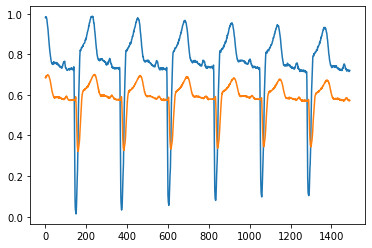

[[35.16489616]]


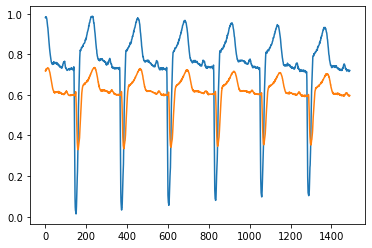

[[29.27970586]]


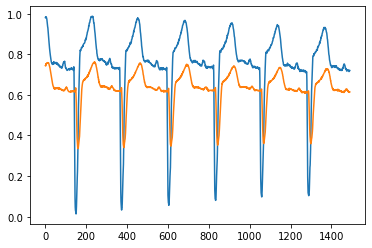

[[25.46604499]]


KeyboardInterrupt: 

In [19]:
np.random.seed(150)
saeid = NN_Elman([10, 15, 1], 'sigmoid', truncate_size= 3,
                 eta_Wy= 0.0001, eta_Wx= 0.0001, eta_Wc= 0.0001)
for epoch in range(20):
    
    #check train loss & prediction
    pred = []
    loss = 0
    for i in range(Y_train.shape[0]):
        pred.append(saeid.predict(X_train[i]))
        loss += ((Y_train[i] - saeid.predict(X_train[i])) ** 2) / 2
    pred = np.array(pred).reshape(-1)
    plt.plot(Y_train)
    plt.plot(pred)
    plt.show()
    print(loss)
    #train
    for i in range(Y_train.shape[0]):
        input_data, nets, states, outputs = saeid.feed_fwd(X_train[i])
        saeid.back_pro(input_data, nets, states, outputs, Y_train[i])

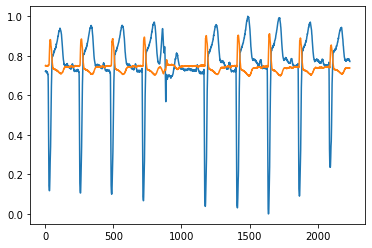

In [113]:
pred = []
for i in range(Y_test.shape[0]):
    pred.append(saeid.predict(X_test[i]))
pred = np.array(pred)

plt.plot(Y_test)
plt.plot(pred.reshape(-1))

In [ ]:
#check test loss
    loss = 0
    for i in range(Y_test.shape[0]):
        loss += ((Y_test[i] - saeid.predict(X_test[i])) ** 2) / 2
    test_loss.append(loss / Y_test.shape[0])
    print(f'Loss in test, epoch {epoch}: ', loss)